# 実験データ

xが同じときの観測を３回ずつ行なうことって、よくやりますよね？

たとえばこんなデータが得られます。

In [1]:
x_observed = [9, 28, 38, 58, 88, 98, 108, 118, 128, 138, 148, 158, 168, 178, 188, 198, 208, 218, 228, 238, 278, 288, 298]
y_observed = [
    [51, 80, 112, 294, 286, 110, 59, 70, 56, 70, 104, 59, 59, 72, 87, 99, 64, 60, 74, 151, 157, 57, 83],
    [54, 109, 113, 314, 310, 115, 77, 90, 50, 63, 127, 43, 55, 76, 65, 108, 58, 44, 54, 130, 139, 46, 87],
    [46, 91, 113, 288, 272, 127, 63, 90, 27, 69, 134, 39, 33, 79, 75, 123, 75, 74, 89, 143, 155, 53, 98]
]

図示してみましょう。

/Users/kot/miniconda3/envs/py3new/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


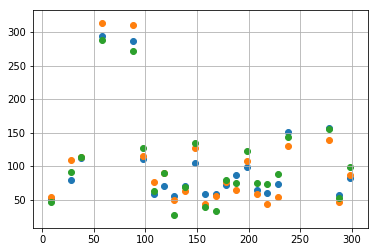

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(x_observed, y_observed[0])
plt.scatter(x_observed, y_observed[1])
plt.scatter(x_observed, y_observed[2])
plt.grid()

# Scipy.interpolateを使って補間する

まずは、補間する区間のxを用意します。たとえば以下のコードでは、観測したxの最小値から最大値まで１００個のxを用意します。

In [3]:
import numpy as np
x_latent = np.linspace(min(x_observed), max(x_observed), 100)

<a href="https://qiita.com/maskot1977/items/913ef108ff1e2ba5b63f">Scipy.interpolate を使った様々な補間法</a>を参考に

In [4]:
from scipy import interpolate
ip1 = ["最近傍点補間", lambda x, y: interpolate.interp1d(x, y, kind="nearest")]
ip2 = ["線形補間", interpolate.interp1d]
ip3 = ["ラグランジュ補間", interpolate.lagrange]
ip4 = ["重心補間", interpolate.BarycentricInterpolator]
ip5 = ["Krogh補間", interpolate.KroghInterpolator]
ip6 = ["2次スプライン補間", lambda x, y: interpolate.interp1d(x, y, kind="quadratic")]
ip7 = ["3次スプライン補間", lambda x, y: interpolate.interp1d(x, y, kind="cubic")]
ip8 = ["秋間補間", interpolate.Akima1DInterpolator]
ip9 = ["区分的 3 次エルミート補間", interpolate.PchipInterpolator]

いろんなのが使えますが、今回は 2次スプライン補間 を使うことにしましょう。３回の実験それぞれで曲線を補間し、その平均を最終的な曲線とします。

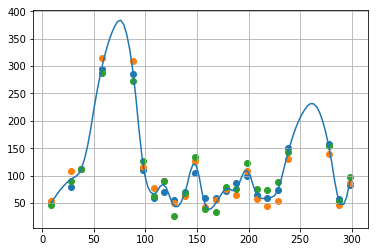

In [5]:
method = ip6[1]
obtained_curve = np.zeros(len(x_latent))
for i in range(len(y_observed)):
    plt.scatter(x_observed, y_observed[i])
    fitted_curve = method(x_observed, y_observed[i])
    #plt.plot(x_latent, fitted_curve(x_latent))
    obtained_curve += np.array(fitted_curve(x_latent))
y_interpolated = obtained_curve / len(y_observed)
plt.plot(x_latent, y_interpolated)
plt.grid()
plt.show()

# 正規分布の線形和で近似するための準備

### バックグラウンドの取得

得られた補間曲線の最小値を background と見なしましょう。

In [6]:
background = min(y_interpolated)
background

38.132222057971255

### 補間曲線を「山」ごとに分割する

scipy.signal の argrelmax, argrelmin を使って、補間曲線の極大値・極小値のインデックスを得ます。

In [7]:
from scipy.signal import argrelmax, argrelmin
print(argrelmax(y_interpolated))
print(argrelmin(y_interpolated))

(array([23, 37, 47, 59, 65, 86]),)
(array([34, 41, 52, 60, 70, 97]),)


次のようにして、極大値と極小値のインデックスの並びを得ます。

In [8]:
min_max_points = sorted([0] + list(argrelmax(y_interpolated)[0]) + list(argrelmin(y_interpolated)[0]) + [len(y_interpolated) - 1])
min_max_points

[0, 23, 34, 37, 41, 47, 52, 59, 60, 65, 70, 86, 97, 99]

この並びの「極小・極大・極小」の組を取り出すことで、補間曲線を「山」ごとに分割します。

区間 [ 9.0 ,  108.25252525252525 ]
区間 [ 108.25252525252525 ,  128.68686868686868 ]
区間 [ 128.68686868686868 ,  160.7979797979798 ]
区間 [ 160.7979797979798 ,  184.15151515151516 ]
区間 [ 184.15151515151516 ,  213.34343434343432 ]
区間 [ 213.34343434343432 ,  292.16161616161617 ]


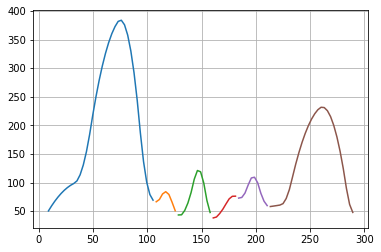

In [9]:
for i in range(len(min_max_points) - 2):
    x1 = min_max_points[i]
    x2 = min_max_points[i + 1]
    x3 = min_max_points[i + 2]
    if y_interpolated[x1] < y_interpolated[x2] and y_interpolated[x2] > y_interpolated[x3]:
        print("区間 [", x_latent[x1], ", ", x_latent[x3], "]")
        plt.plot(x_latent[x1:x3], y_interpolated[x1:x3])
plt.grid()
plt.show()

### 「山」ごとにガウス関数で近似する（予備的）

山ごとに、高さ amp 、中心 ctr 、 幅 wid のガウス関数に近似します。高さ amp と中心 ctr はすぐ求められるので、誤差が最小になるように幅を最適化します。ただし、この近似はあとで微調整しますので、今回は簡単な近似で構いません。

In [10]:
import numpy as np
def gauss_fit(X, Y):
    amp = np.max(Y)
    ctr = X[np.argmax(Y)]
    wid = 1
    prev_gosa = 1e10000
    gosa = 1e1000
    while gosa <= prev_gosa:
        prev_gosa = gosa
        gosa = 0
        gauss_curve = []
        for x, y in zip(X, Y):
            y_calc = amp * np.exp( -((x - ctr)/wid)**2) # ガウス関数
            gauss_curve.append(y_calc)
            gosa += (y - y_calc)**2
        wid += 0.1
    
    return (amp, ctr, wid, gauss_curve) # 高さ amp 、中心 ctr 、 幅 wid と、近似されたガウス曲線 gauss_curve を返す

「山」ごとに得られたパラメータ（高さ amp 、中心 ctr 、 幅 wid ）を「guess」という変数に蓄積します。この「guess」は、次の計算に用います。「山」ごとに、補間曲線と、ガウス関数による近似曲線を図示してみましょう。

Amp= 345.5974564980024  Ctr= 76.14141414141415  Wid= 26.50000000000011
Amp= 45.84617311827008  Ctr= 117.01010101010101  Wid= 9.599999999999984
Amp= 82.87082624341119  Ctr= 146.2020202020202  Wid= 8.699999999999987
Amp= 38.01302071374993  Ctr= 181.23232323232324  Wid= 12.199999999999974
Amp= 71.14974949173202  Ctr= 198.74747474747474  Wid= 12.399999999999974
Amp= 193.45719588760835  Ctr= 260.0505050505051  Wid= 24.600000000000083


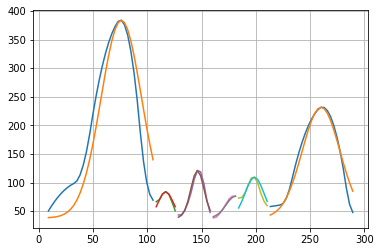

In [11]:
guess = []
for i in range(len(min_max_points) - 2):
    x1 = min_max_points[i]
    x2 = min_max_points[i + 1]
    x3 = min_max_points[i + 2]
    if y_interpolated[x1] < y_interpolated[x2] and y_interpolated[x2] > y_interpolated[x3]:
        amp, ctr, wid, gauss_curve = gauss_fit(x_latent[x1:x3], y_interpolated[x1:x3] - background)
        guess.append([amp, ctr, wid])
        print("Amp=", amp, " Ctr=", ctr, " Wid=", wid)
        plt.plot(x_latent[x1:x3], y_interpolated[x1:x3])
        plt.plot(x_latent[x1:x3], gauss_curve + background)
plt.grid()
plt.show()

# 正規分布の線形和で近似する


以上で準備が整いました。これまでの過程は、正規分布の線形和で近似するにあたって、「何個の」「どのような正規分布で」近似すればいいかを粗く見積もるための計算でした。見積もりの結果は「guess」と「background」という変数に格納されています。

ここからしばらくは、<a href="https://qiita.com/kon2/items/6498e66af55949b41a99">研究者のための実践データ処理～Pythonでピークフィッティング～</a>のコードをそのまま使用させていただきます。

In [12]:
# そのまえに、変数名を調整します。
x = x_latent
y = y_interpolated

### コードを借用します

In [13]:
# 研究者のための実践データ処理～Pythonでピークフィッティング～
# https://qiita.com/kon2/items/6498e66af55949b41a99 のコードそのままです。

def func(x, *params):

    #paramsの長さでフィッティングする関数の数を判別。
    num_func = int(len(params)/3)

    #ガウス関数にそれぞれのパラメータを挿入してy_listに追加。
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
        y_list.append(y)

    #y_listに入っているすべてのガウス関数を重ね合わせる。
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i

    #最後にバックグラウンドを追加。
    y_sum = y_sum + params[-1]

    return y_sum

In [14]:
# 研究者のための実践データ処理～Pythonでピークフィッティング～
# https://qiita.com/kon2/items/6498e66af55949b41a99 のコードそのままです。

def fit_plot(x, *params):
    num_func = int(len(params)/3)
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2) + params[-1]
        y_list.append(y)
    return y_list

In [15]:
# 「guess」を作る部分以外は、
# 研究者のための実践データ処理～Pythonでピークフィッティング～
# https://qiita.com/kon2/items/6498e66af55949b41a99 のコードそのままです。

#初期値リストの結合
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

In [16]:
# 最大計算回数 maxfev = 40000 というパラメータだけ調整しました。

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, x, y, p0=guess_total, maxfev = 40000)

# 近似計算の結果

### 近似曲線を図示

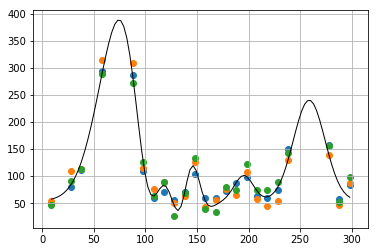

In [17]:
fit = func(x, *popt)
plt.scatter(x_observed, y_observed[0])
plt.scatter(x_observed, y_observed[1])
plt.scatter(x_observed, y_observed[2])
plt.plot(x, fit , ls='-', c='black', lw=1)
plt.grid()

### 近似曲線のパラメータを取得

In [18]:
print(popt)

[ 3.67612441e+02  7.99163380e+01  3.28914988e+01  3.24163231e+04
  1.19574414e+02  2.11898045e+01  1.83701449e+02  1.44455636e+02
  1.14296066e+01 -3.24762415e+04  1.19545626e+02 -2.13210624e+01
  4.73074263e+01  1.95375969e+02  1.29812480e+01  1.86434656e+02
  2.58692641e+02  2.16153699e+01  5.40074660e+01]


### 近似曲線の式を得たい

Sympy の使い方は <a href="https://qiita.com/maskot1977/items/51caa6c8cbf8a2c691db">積分をPythonで理解する</a> などをご参考に。

In [19]:
import sympy as sym
from sympy.plotting import plot
sym.init_printing(use_unicode=True)

x, y = sym.symbols("x y")

以下が、各々のガウス分布のパラメータです。

In [20]:
expr = 0
for i in range(len(popt) - 1):
    if i%3 == 0:
        amp = popt[i]
        ctr = popt[i + 1]
        wid = popt[i + 2]
        print("Amp= ", amp, ",\tCtr= ", ctr, ",\tWid= ", wid)
        expr += amp * sym.exp( -((x - ctr)/wid)**2)
expr += popt[-1]
print("Background = ", popt[-1])

Amp=  367.6124414285456 ,	Ctr=  79.91633803176322 ,	Wid=  32.89149875522794
Amp=  32416.32307342323 ,	Ctr=  119.57441378759701 ,	Wid=  21.189804453210737
Amp=  183.7014485611132 ,	Ctr=  144.4556361867466 ,	Wid=  11.429606629060402
Amp=  -32476.241510624808 ,	Ctr=  119.54562628253437 ,	Wid=  -21.32106243282284
Amp=  47.30742631721358 ,	Ctr=  195.37596874838505 ,	Wid=  12.981248036610742
Amp=  186.43465567903263 ,	Ctr=  258.6926411130064 ,	Wid=  21.61536992374812
Background =  54.007466043413466


In [21]:
display(sym.Eq(y, expr))

/Users/kot/miniconda3/envs/py3new/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


以上のように、近似式が得られました。